# Notebook de démonstration. (Groupe fréquentiel.)

Ce notebook illustre la propagation d’un signal thermique périodique dans un milieu poreux saturé selon la théorie de Stallman (1965).
L’objectif est de retrouver les paramètres effectifs du milieu — la diffusivité thermique $\kappa_e$ et la vitesse advective effective $v_t$ — à partir d’un jeu de signaux synthétiques simulant la colonne MOLONARI.


L'équation de diffusion à l'origine du phénomène.
$$
\frac{\partial \theta}{\partial t}
= \kappa_e \frac{\partial^2 \theta}{\partial z^2}
+ \frac{\rho_w c_w}{\rho_m c_m} K \frac{\partial H}{\partial z} \frac{\partial \theta}{\partial z}
$$
La solution analytique donnée par Stallman est :
$$
\theta(z,t) = \theta_\mu + \theta_{\text{amp}} e^{-az} \cos\!\left(\frac{2\pi}{P}t - bz\right)
$$

# Analyse fréquentielle des transferts thermiques dans le lit de rivière.

Ce notebook illustre comment on peut, à partir de signaux de température mesurés à différentes profondeurs,
retrouver les paramètres effectifs de transfert de chaleur dans un milieu poreux saturé :
- la **diffusivité thermique effective** $ \kappa_e $,
- la **vitesse advective thermique** $ v_t $.

On utilise ici des données synthétiques générées avec le modèle MOLONARI et on applique la méthode fréquentielle de Stallman (1965).

**Remarque** : Verifier que l'environement `pyheatmy` est activé et non corrompu avant d'exécuter le reste du code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyheatmy import *
from datetime import datetime, timedelta
import os, csv

from IPython.display import display, Markdown

### Création des signaux synthétiques.

Dans un premier temps, on doit définir les paramètres physiques de la simulation et de la colonne.
**Ce point peut être confus, mais c'est bien `Zbottom` qui est utilisé dans le calcul du gradient de charge hydraulique.**

In [2]:
Zbottom = .4  
depth_sensors = [0.1, 0.2, 0.3, 0.4]

Layer1 = Layer.from_dict({
    "name": "Sable homogène",
    "zLow": Zbottom,
    "moinslog10IntrinK": 12,
    "n": 0.1,
    "lambda_s": 1.0,
    "rhos_cs": 4e6,
    "q": 0,
})

On initialise les paramètres de fenêtrage et de forçage temporel. 

> Pour créer un signal multipériodique, il faut utiliser le format :
> `[[offset], [ampl1, period1, phase1], [ampl2, period2, phase2], ...]`

param_T_riv_signal is a list of list, generating multi periodic signal
Initializing time series of synthetic_MOLONARI
param_time_dates: [(2011, 1, 1), (2011, 2, 28, 23, 59, 59), 900]
param_dH_signal: [[0.05], [0, 9999, 0]]
param_T_riv_signal: [[285.15], [1, 86400, 0], [1, 2592000, 0]]
param_T_aq_signal: [[285.15], [0, 9999, 0]]
sigma_meas_P: None
sigma_meas_T: None
Multiple periodic signals detected, summing components with global offset.


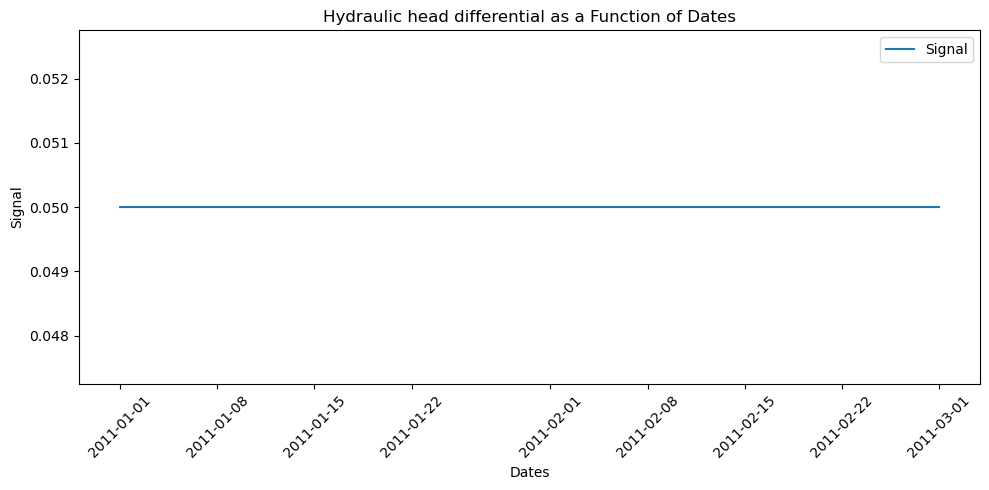

Multiple periodic signals detected, summing components with global offset.


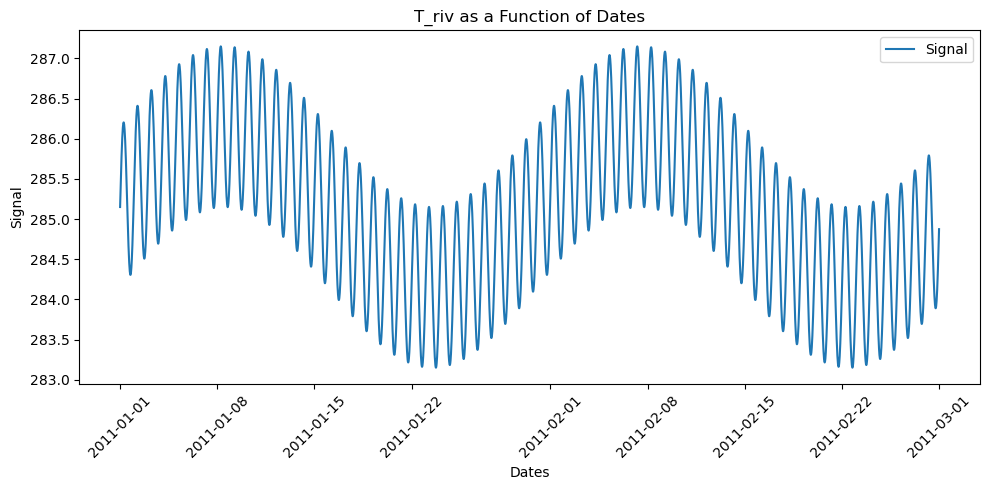

Multiple periodic signals detected, summing components with global offset.


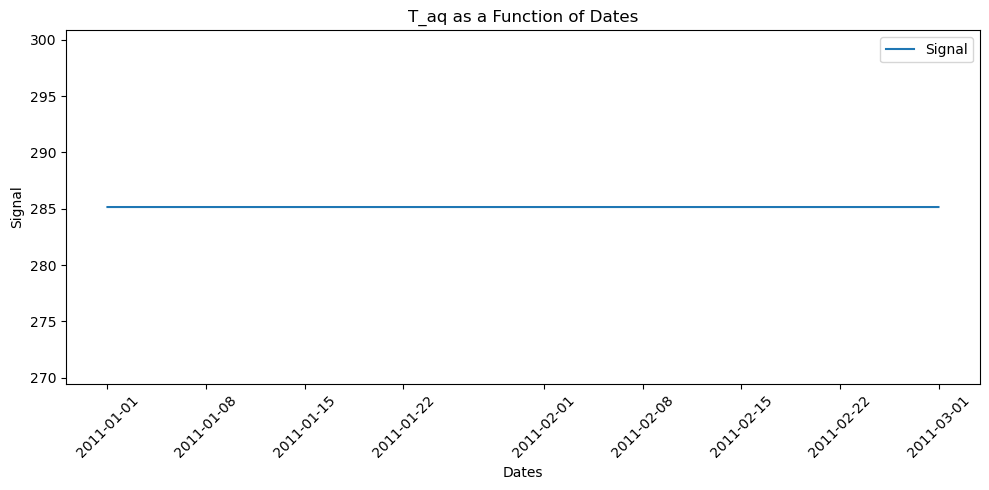

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [285.1499939  285.20069122 285.25115967 ... 284.84294891 284.89295959
 284.94340515]
Temperature of Sensor 1 : [285.1499939  285.18379211 285.21743774 ... 284.94529724 284.9786377
 285.01226807]
Temperature of Sensor 2 : [285.1499939  285.16689301 285.18371582 ... 285.04764557 285.0643158
 285.08113098]
Temperature of Sensor 3 : [285.1499939 285.1499939 285.1499939 ... 285.1499939 285.1499939
 285.1499939]


In [3]:
t_debut = (2011,1,1); t_fin = (2011,2,28,23,59,59)
dt = 15*NSECINMIN  # pas de 15 s
T_riv_amp, T_riv_offset = 1, 12 + ZERO_CELSIUS
nday = 1
P_T_riv = nday*NHOURINDAY*4*dt  # période ≈ 1 jour

dH_offset = 0.05  # différence de charge hydraulique entre la surface et le fond

liste_params_river = [[T_riv_offset], [T_riv_amp, P_T_riv, 0], [1, P_T_riv*30, 0]]
liste_params_aq = [[T_riv_offset], [0, 9999, 0]]
liste_params_dH = [[dH_offset], [0, 9999, 0]]


time_series_dict = {
    "offset": 0.0,
    "depth_sensors": depth_sensors,
    "param_time_dates": [t_debut, t_fin, dt],
    "param_dH_signal": liste_params_dH,
    "param_T_riv_signal": liste_params_river,
    "param_T_aq_signal": liste_params_aq
}
emu = synthetic_MOLONARI.from_dict(time_series_dict)

### Résolution du modèle direct 1D.

On lance la résolution du modèle direct via `pyheatmy`.
**Pour respecter la structure 1D du modèle, verifier que `q=0`, autrement on impose un flux.**

In [4]:
col = Column.from_dict({
    "river_bed": 1,
    "depth_sensors": depth_sensors,
    "offset": 0.0,
    "dH_measures": emu._molonariP_data,
    "T_measures": emu._T_Shaft_measures,
    "nb_cells": 100,
    "sigma_meas_P": 0.0,
    "sigma_meas_T": 0.0,
}, verbose=False)

col.set_layers(Layer1)
col.compute_solve_transi()
emu._measures_column_one_layer(col)

--- Compute Solve Transi ---
One layer : moinslog10IntrinK = 12, n = 0.1, lambda_s = 1.0, rhos_cs = 4000000.0, q = 0
Solving the flow with intrinsec permeability 1e-12, and permeability 9.810000000000001e-06
Done.


## Analyse fréquentielle.

L'analyse fréquentielle est effectuée avec le module que nous avons crée : `frequentiel_analysis`. Verifier que ce module est bien localisé dans les fichiers sources de MOLONARI.

### Initialisation de l'analyseur.

In [ ]:
from pyheatmy.frequency import frequency_analysis
fa = frequency_analysis()

Frequency analysis module initialized.
This module will analyze a multi-periodic signal to estimate attenuation and phase decay coefficients.
Using phase decay and amplitude attenuation with depth, we'll retrieve kappa_e and v_t for each dominant period.
-------------------------------------
Please use set_inputs(...) to provide the necessary data before analysis.


On assigne les dates et les signaux aux variables.

In [6]:
dates = emu._dates
river = emu._T_riv
temps_all = col.get_temperature_at_sensors()
signals = [river] + [temps_all[i, :] for i in range(1, temps_all.shape[0]-1)]
depths = [0.0] + list(depth_sensors)
signals = np.array(signals)

Maintenant on fourni à la classe les signaux et les informations.

In [7]:
fa.set_inputs(dates=dates, signals=signals, depths=depths[:-1])

On peut aussi fournir les informations physiques si on les a. En activant `compute_now`, on calcule directement les valeurs de $\kappa_e$ et de $v_t$ attendues.

In [8]:
POROSITE = Layer1.params[1]
LAMBDA_S = Layer1.params[2]
RHO_CS = Layer1.params[3]
K_INTRIN = 10**(-Layer1.params[0])
GRAD_H = - dH_offset / Zbottom  # gradient hydraulique

fa.set_phys_prop(lambda_s=LAMBDA_S,
                 rho_c_s=RHO_CS,
                 k=K_INTRIN,
                 n=POROSITE,
                 gradH=GRAD_H,
                 compute_now=True,
                 verbose=True)

[set_phys_prop] Effective parameters computed:
  kappa_e = 2.378e-07 m²/s
  v_t = 1.274e-06 m/s


Maintenant on peut effectuer les premières actions

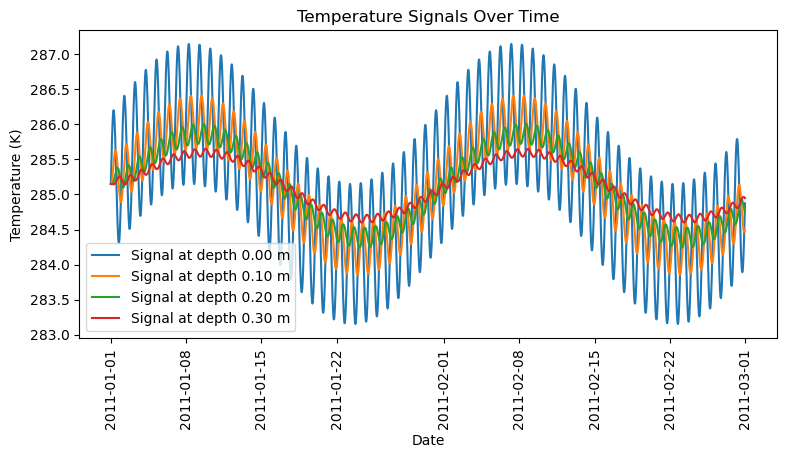

/Users/noedaniel/Desktop/Freq_Molonari/MOLONARI1D/pyheatmy/frequency_last_v.py:536: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1.0 / (freqs * 86400.0), amp, label=f'Sensor at depth {depths[i]} m')


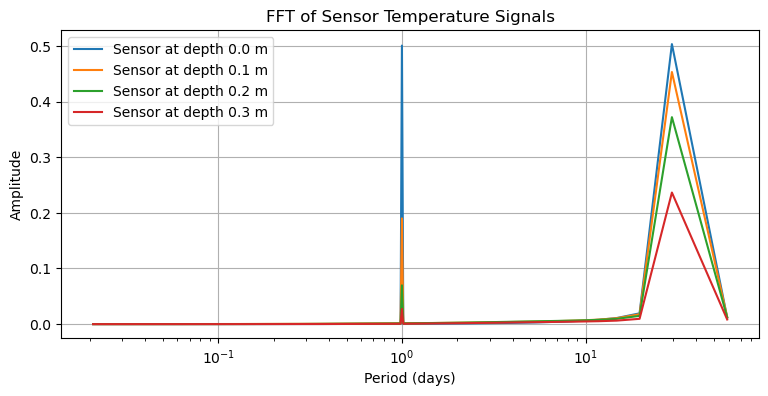

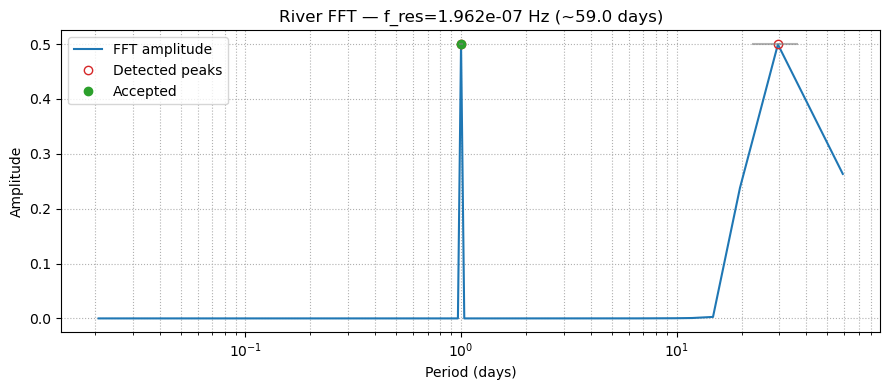

In [9]:
fa.plot_signals()
fa.fft_sensors()
Pd, f0, A0, meta = fa.find_dominant_periods(store=True, compute_phases=True)

Default 1D analysis has been selected. 
 This model will not deal with possible 2D analysis.
Detected depths: [0.  0.1 0.2 0.3]
Amplitudes at dominant periods for each signal computed.
Period 1.00 days: Amplitudes = [0.50056115 0.19003435 0.06971945 0.02739393]


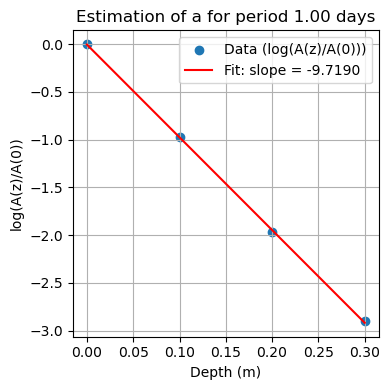

Attenuation coefficients a estimated for each dominant period.
Period 1.00 days: a = 9.7190 1/m
Period 1.00 days: R^2 = 0.9998


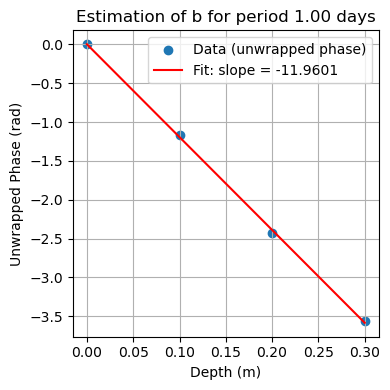

Phase decay coefficients b estimated for each dominant period.
Period 1.00 days: b = 11.9601 rad/m
Period 1.00 days: R^2 = 0.9997
Inversion complete.
Period 1.00 days: kappa_e = 2.488e-07 m^2/s, v_t = 1.244e-06 m/s


In [10]:
a_est, a_R2 = fa.estimate_a(allow2D=False, draw=True)     # lit dates/signals/depths/Pd depuis le state
b_est, b_R2 = fa.estimate_b(draw=True)                    # idem
kappa_e, v_t = fa.perform_inversion(verbose=True)         # lit a,b,Pd du state

Check if we find similar values for $a$ and $b$ from the exact physical parameters.

In [16]:
a_expected, b_expected = fa.phys_to_a_b()
for p, a, b in zip(Pd, a_expected, b_expected):
    print(f"Period {p:.2f} days: expected a = {a} 1/m, b = {b} 1/m")
    

Period 1.00 days: expected a = 9.833676259871822 1/m, b = 12.221999839747385 1/m
